In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import random
import math
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
troponin = pd.read_csv("data/CAE_TnT_original_data.csv")

In [4]:
print(troponin)

     Result_TNT Flag_TNT      Sample ID Blood drawn date    Study ID P01  \
0          3.00    <Test         LN001A         7/1/2009  02-1-01ZL1 001   
1          3.00    <Test         LN001B        7/20/2009  02-1-01ZL1 001   
2          3.00    <Test         LN001C        8/10/2009  02-1-01ZL1 001   
3          3.34      NaN         LN001D        9/21/2009  02-1-01ZL1 001   
4         71.71        H         LN002A         7/3/2009  02-1-01ZL1 002   
..          ...      ...            ...              ...             ...   
837        3.87      NaN  Lab9-307-271H       11/23/2016  02-1-04ZL1-007   
838        5.44      NaN  Lab9-307-319A        3/10/2014  02-1-04ZL1-009   
839       10.14      NaN  Lab9-307-319B         4/1/2014  02-1-04ZL1-009   
840        9.20      NaN  Lab9-307-319C        4/14/2014  02-1-04ZL1-009   
841        6.81      NaN  Lab9-307-319D        6/16/2014  02-1-04ZL1-009   

      tmtstart     tmtend  
0     7/1/2009  8/20/2009  
1     7/1/2009  8/20/2009  
2  

In [5]:

#Step 1: Get uniuqe list of ID's
temp = troponin.iloc[:,4].unique()
unique = [x for x in temp if isinstance(x,str)]
uniqueID = np.array(unique)

n_pat = uniqueID.shape[0]
n_obs = troponin.shape[0]

In [6]:
print(n_pat)
print(n_obs)


200
842


In [7]:
#Create tensor of [N patients x K time points x D dimensions]


c = 0
a = 0
time = np.zeros(n_obs)
ID = []
for i in range(n_obs - 1):
    
    
    if troponin.iloc[i,4] != troponin.iloc[i+1,4]:
        
        time[a] = 0
        a = i + 1
        
        ID.append(c)
        c = c + 1

    else:
        hold = troponin.iloc[a,3] 
        x = pd.to_datetime(troponin.iloc[i+1,3]) -  pd.to_datetime(hold)
        time[i+1] = x.total_seconds()/86400
        ID.append(c)
            
ID.append(c)
ID = np.array(ID).reshape((n_obs,1))
values =  troponin.iloc[:,0].values.reshape((n_obs,1))
mask = np.ones(n_obs).reshape((n_obs,1))
cov = np.zeros(n_obs).reshape((n_obs,1))
ID = ID.reshape((n_obs,1))
time = time.reshape((n_obs,1))

In [29]:
#Standardize data
meangt_troponin = np.mean(values)
stdgt_troponin = np.std(values)


#values = ( values -  meangt_troponin)/stdgt_troponin


In [9]:

full = np.concatenate((ID,time,values,mask,cov),axis=1)
columns = ['ID','Time','Value_0','Mask_0','Cov']

In [10]:
df = pd.DataFrame(full, columns = columns)
df.to_csv('processed_data/troponin_gt.csv',index=False)

In [11]:
# Hold out the second time step

"""
holdout = []
k = 2 #Time point to holdout
for i in range(n_obs - 1):
    
    if full[i,0] != full[i+1,0]: #Then i + 1 is next patient so skip i + 2
        a = 0
        
    a = a + 1
    if a == k + 1:
        continue
        
    holdout.append(full[i,:])
    
holdout = np.array(holdout)
holdout = np.delete(holdout, 1, 0)   

"""

holdout = []
for i in range(n_obs - 1):
    
    if full[i,0] == full[i+1,0]: #Then i + 1 is next patient so skip i + 2
        holdout.append(full[i,:])
    
holdout = np.array(holdout)
 
        
        

In [12]:
df = pd.DataFrame(holdout, columns = columns)
df.to_csv('processed_data/troponin_holdout.csv',index=False)

In [21]:
T = holdout[:,1].max()
delta_t = 1
N = holdout.shape[0]

In [14]:
print(T)
print(N)

969.0
642


In [22]:
#create metadata for GRU-ode run
metadata_dict = {"T":T,"delta_t":delta_t,"N":N}
np.save("processed_data/troponin_holdout_metadata.npy",metadata_dict)


In [16]:
os.getcwd()

'/gpfs/ysm/home/of56/MGH'

In [53]:
print(T)

969.0


In [17]:
# Create tensor of patients

print(full)
patensor = []
j = 0
a = 0
for i in range(n_obs - 1):
    if full[i,0] == full[i + 1, 0]:
        a += 1
    else:
        patensor.append(full[i-a:i+1,:])
        a = 0
        
patensor.append(full[-4:,:])


[[  0.     0.     3.     1.     0.  ]
 [  0.    19.     3.     1.     0.  ]
 [  0.    40.     3.     1.     0.  ]
 ...
 [199.    22.    10.14   1.     0.  ]
 [199.    35.     9.2    1.     0.  ]
 [199.    98.     6.81   1.     0.  ]]


# Run GRU-ODE and analyze output

In [23]:
# Train GRU-ODE Model

%run -i '/home/of56/gru_ode_bayes/experiments/double_OU/double_ou_gruode.py'

513
129


0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:232: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
3it [00:03,  1.14s/it]

Loss tensor(6164.6191, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 0



/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:232: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])


(1031,)
torch.Size([1031, 64, 2])
Done


<Figure size 432x288 with 0 Axes>

In [115]:
#Load model output
obs_ID = np.load("obs_id.npy")
modeloutput = np.load("mean_cov.npy")
times = np.load("time.npy")
modeloutput = np.load("predictions.npy")


ntime = [round(x,1) for x in times]


In [116]:
print(times.shape)
print(modeloutput.shape)
print(samp.shape)

(1031,)
(1020, 37, 2)
(5, 1)


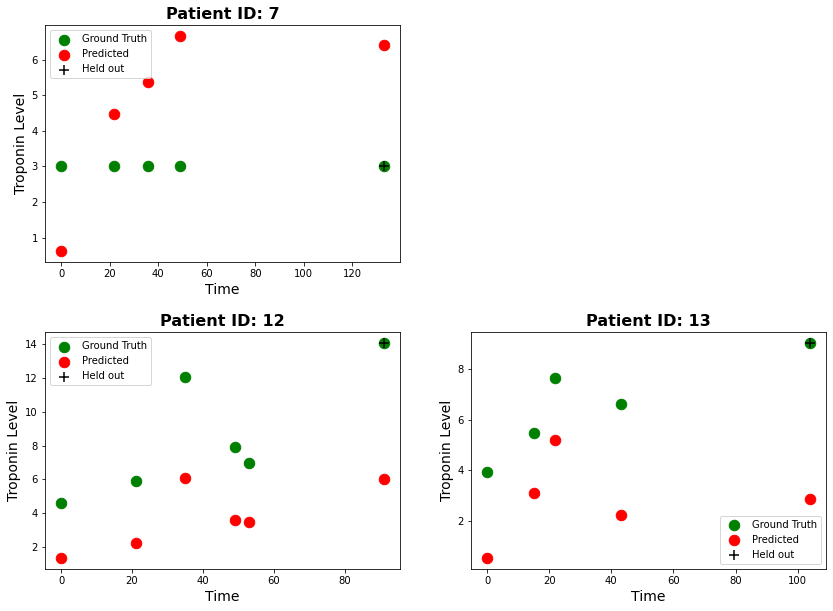

In [121]:


#Plotting
totpred = []
totgrd = []
totimes = []

%matplotlib inline
plt.figure(figsize=(14,10))
for i in range(4): #Looping through 4 different patients
    

    
    patID = np.random.choice(np.arange(modeloutput.shape[1]),replace=True) #select patient ID
    samp = []
    for k in range(patensor[patID].shape[0]): #Get time index
        tindx = np.argwhere(ntime == patensor[patID][k,1])[0]
        X = modeloutput[tindx,patID,:]
        samp.append(np.random.normal(X[:,0],np.sqrt(np.abs(X[:,1])))) # Get model predictions for each time point
        #X = modeloutput[:,patID,:]
        #samp.append(np.random.normal(X[:,0],np.sqrt(np.abs(X[:,1])))) # Get model predictions for each time point
    samp = np.array(samp)
    
    if patensor[patID].shape[0] < 3:
        continue
        
        


    plt.subplot(2,2,i+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.scatter(patensor[patID][:,1],patensor[patID][:,2],c='green',s=110)
    plt.scatter(patensor[patID][:,1],samp,c='red',s=110)
    #plt.plot(times,samp,c='red',s=110)
    plt.scatter(patensor[patID][-1,1],patensor[patID][-1,2],c='black',marker='+',s=100)
    plt.title("Patient ID: " + str(patID),fontsize=16,fontweight = 'bold')
    plt.xlabel("Time",fontsize=14)
    plt.ylabel("Troponin Level",fontsize=14)
    plt.legend(['Ground Truth','Predicted','Held out'])


In [33]:
# Discard outliers



print(meangt_troponin)


9.433764845605701


In [86]:

#Get mean of value of held out time point for all patients

ltimep = []
for j in range(n_pat):
    ltimep.append(patensor[j][-1,2])
mltimep = np.array(ltimep).mean()
    
perrstats = [] 
for j in range(100):
    #MSE computation
    perr = []
    se = []
    abserr = []

    totpred = []
    totgrd = []
    totimes = []
    toterr = []
    for i in range(modeloutput.shape[1]):

        if patensor[i].shape[0] < 3:
            continue

        if np.abs(patensor[i][-1,2]) > meangt_troponin + np.abs(stdgt_troponin)*2:
            continue



        tindx = np.argwhere(ntime == patensor[i][-1,1])[0]
        X = modeloutput[tindx,i,:]


        samp = np.random.normal(X[0,0],np.sqrt(np.abs(X[0,1])))

        gt = (patensor[i][-1,2] * stdgt_troponin) + meangt_troponin
        pred = (samp * stdgt_troponin) +  meangt_troponin

        perr.append( (np.abs((gt - pred))/gt)*100 )
        #perr.append( (np.abs((patensor[i][-1,2] - samp))/patensor[i][-1,2])*100 )
        se.append( (patensor[i][-1,2] - samp)**2 )
        abserr.append( np.abs((patensor[i][-1,2] - samp)) )


        totpred.append(samp)
        totgrd.append(patensor[i][-1,2])
        totimes.append(patensor[i][-1,1])


    mse = np.mean(se)
    mperr = np.mean(perr)
    maxerr = np.max(abserr)
    
perrstats.append(mperr)
print(np.mean(perrstats))


52.32386654441237


Text(0, 0.5, 'Percent Error')

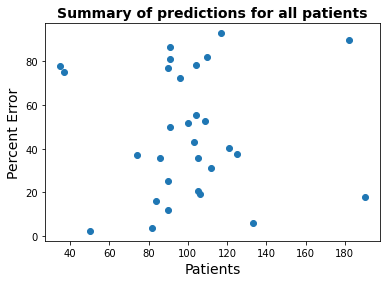

In [84]:

plt.figure()
plt.title("Summary of predictions for all patients",fontweight='bold',fontsize=14)
#plt.scatter(totimes,totpred)
#plt.scatter(totimes,totgrd)
plt.scatter(totimes,perr)
plt.xlabel("Patients",fontsize=14)
plt.ylabel("Percent Error",fontsize=14)




In [85]:
print("Mean squared error")
print(mse)
print("Mean percent error")
print(mperr)
print("Max error")
print(maxerr)

Mean squared error
93.91166078930736
Mean percent error
46.859778430238336
Max error
22.61923415369973


In [97]:
#Save predictions
#np.save("predictions_stpsz_pten_3.npy",modeloutput)


In [93]:
# Base line regression prediction




#Get first 3 time points as training data
X = []
Y = []

for i in range(n_pat):
    
    if patensor[i].shape[0] < 5:
        continue
        
        
    if np.abs(patensor[i][-1,2]) > meangt_troponin + np.abs(stdgt_troponin)*2:
        continue
        
    
    X.append(patensor[i][:4,2])
    Y.append(patensor[i][:4,1])
    
X = np.array(X)
Y = np.array(Y)


In [57]:
print(X.shape)
print(Y.shape)

(93, 4)
(93, 4)


In [58]:
#Average number of time points
c = []
for i in range(n_pat):
    c.append(len(patensor[i][:,0]))
    
print(np.mean(c))

4.21


In [94]:
#Train test split


indx = np.random.choice(np.arange(X.shape[0]),size=X.shape[0])
ntrain = int(round(0.2*len(indx)))
traind = indx[:ntrain]
testind = indx[ntrain:]

X_train = X[traind,:2]
X_test = X[testind,:2]

y_train = X[traind,2:]
y_test = Y[testind,2:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)





#Create personal train/test fit


(19, 2)
(74, 2)
(19, 2)
(74, 2)


81.20715264163162
-8.954727250288364
79.45765285683656


Text(0, 0.5, 'Percent Error')

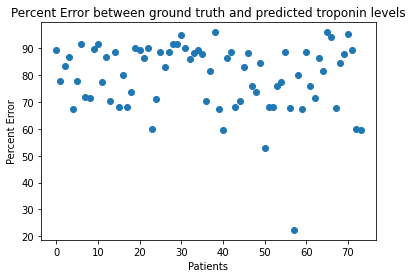

In [97]:
#Complete Linear regression

regperr = []
for k in range(100):
    
    

    indx = np.random.choice(np.arange(X.shape[0]),size=X.shape[0])
    ntrain = int(round(0.2*len(indx)))
    traind = indx[:ntrain]
    testind = indx[ntrain:]

    X_train = X[traind,:2]
    X_test = X[testind,:2]

    y_train = X[traind,2:]
    y_test = Y[testind,2:]

    lreg = LinearRegression().fit(X_train,y_train)
    y_pred = lreg.predict(X_test)
    perreg = np.abs( (y_pred[:,1] - y_test[:,1])/y_test[:,1] ) * 100
    regperr.append(perreg)

print(np.mean(regperr))
print(np.max(y_pred[:,1]-y_test[:,1]))

print(np.mean(perreg))


plt.figure()
plt.plot()
plt.title("Percent Error between ground truth and predicted troponin levels")
plt.scatter(np.arange(len(perreg)),perreg)
plt.xlabel("Patients")
plt.ylabel("Percent Error")



124.255
56.97155516639235


Text(0, 0.5, 'Percent Error')

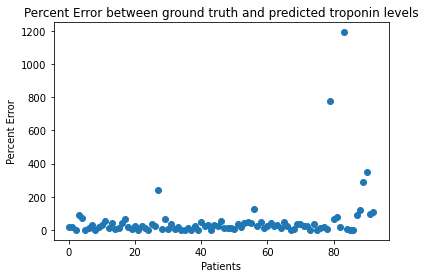

In [43]:
#Extrapolation

m = []
xn = []
yn = []
xextp = []
ygt = []
for i in range(n_pat):

    if patensor[i].shape[0] < 5:
        continue
        
    if np.abs(patensor[i][-1,2]) > meangt_troponin + np.abs(stdgt_troponin)*2:
        continue
        
        
    rise = patensor[i][2,2] -  patensor[i][0,2]
    run = patensor[i][2,1] -  patensor[i][0,1]
    xn.append(patensor[i][2,1])
    yn.append(patensor[i][2,2])
    xextp.append(patensor[i][3,1])
    ygt.append(patensor[i][3,2])

    m.append( rise/run ) 
    
yn = np.array(yn)
xn = np.array(xn)
m = np.array(m)
xextp = np.array(xextp)

#Perform extrapolation/record error
yextp = yn + m*(xextp - xn)
perregextp = np.abs( (yextp - ygt)/ygt ) * 100


# display results
print(np.max(yextp - ygt))
print(np.mean(perregextp))
plt.figure()
plt.plot()
plt.title("Percent Error between ground truth and predicted troponin levels")
plt.scatter(np.arange(len(perregextp)),perregextp)
plt.xlabel("Patients")
plt.ylabel("Percent Error")
